<a href="https://colab.research.google.com/github/Gooogr/YOLO_toolkit/blob/public_deploying/OpenImagesV4Loader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The task of this notebook is to download and prepare a custom YOLO dataset based on Open Image Dataset v4.<br>
Used API for that: [OIDv4_ToolKit](https://github.com/theAIGuysCode/OIDv4_ToolKit)

In [0]:
import cv2
import numpy as np
import os
import fnmatch
from google.colab.patches import cv2_imshow
import re


In [2]:
! pip install awscli

     |████████████████████████████████| 3.1MB 4.5MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 6.2MB 35.3MB/s 
  Found existing installation: rsa 4.0
    Uninstalling rsa-4.0:
      Successfully uninstalled rsa-4.0
  Found existing installation: botocore 1.16.19
    Uninstalling botocore-1.16.19:
      Successfully uninstalled botocore-1.16.19


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

# create a symbolic sub-link to avoid 'space' problem
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
 colab_notebooks			   Hackatons
'Commnad to sinhronize.txt'		  'Wake up script.docx'
 datasets				   YOLO_toolkit
 DIY					   YOLO_Toolkit_Public
'Docker command for tf gpu with jupyter'


#### OIDv4 Toolkit preparation

In [0]:
def setup_OIDv4Toolkit():
  # Clone tookit for Open Image Dataset v4
  % cd /mydrive/YOLO_toolkit
  ! git clone https://github.com/theAIGuysCode/OIDv4_ToolKit

  % cd OIDv4_ToolKit
  ! pip install -r requirements.txt


In [5]:
# Uncomment if you run this notebook for the first time
setup_OIDv4Toolkit()

/content/gdrive/My Drive/YOLO_toolkit
Cloning into 'OIDv4_ToolKit'...
remote: Enumerating objects: 444, done.
remote: Total 444 (delta 0), reused 0 (delta 0), pack-reused 444
Receiving objects: 100% (444/444), 34.09 MiB | 18.71 MiB/s, done.
Resolving deltas: 100% (158/158), done.
/content/gdrive/My Drive/YOLO_toolkit/OIDv4_ToolKit


#### Preparing  dataset




In [6]:
% cd /mydrive/YOLO_toolkit/OIDv4_ToolKit
# Don't forget to specify --classes and --limit keys.
# Don't change --multiclasses key value. YOLO requires that all files be in the same folder.
! python3 main.py downloader -y --classes Human_face Human_hand --type_csv train --limit 1000 --multiclasses 1

/content/gdrive/My Drive/YOLO_toolkit/OIDv4_ToolKit

		   ___   _____  ______            _    _    
		 .'   `.|_   _||_   _ `.         | |  | |   
		/  .-.  \ | |    | | `. \ _   __ | |__| |_  
		| |   | | | |    | |  | |[ \ [  ]|____   _| 
		\  `-'  /_| |_  _| |_.' / \ \/ /     _| |_  
		 `.___.'|_____||______.'   \__/     |_____|
	

             _____                    _                 _             
            (____ \                  | |               | |            
             _   \ \ ___  _ _ _ ____ | | ___   ____  _ | | ____  ____ 
            | |   | / _ \| | | |  _ \| |/ _ \ / _  |/ || |/ _  )/ ___)
            | |__/ / |_| | | | | | | | | |_| ( ( | ( (_| ( (/ /| |    
            |_____/ \___/ \____|_| |_|_|\___/ \_||_|\____|\____)_|    
                                                          
        
    [INFO] | Downloading ['Human face', 'Human hand'] together.
   [ERROR] | Missing the class-descriptions-boxable.csv file.
[DOWNLOAD] | Automatic download.
...145%, 0

In [14]:
!pwd

/content/gdrive/My Drive/YOLO_toolkit/OIDv4_ToolKit


In [16]:
# Edit classes in OIDv4_ToolKit/classes.txt.
# Write them exactly as in key --classes
! cat classes.txt

Apple
Orange
Light switch


In [17]:
# Convert annotations to normalazied YOLO version. 
! python convert_annotations.py

Currently in subdirectory: train
Converting annotations for class:  Human face_Human hand
100% 196/196 [00:10<00:00, 18.58it/s]


In [18]:
# Remove old labels. Count files amount in the dataset (images + labels).
# Name of dataset folder corresponds to the selected labels types: <Class name 1>_<Class name 2>_ ...
! rm -r /mydrive/YOLO_toolkit/OIDv4_ToolKit/OID/Dataset/train/'Human face_Human hand'/Label
! ls /mydrive/YOLO_toolkit/OIDv4_ToolKit/OID/Dataset/train/'Human face_Human hand'/ | wc -l

392


In [0]:
# Move dataset folder to the root of working directory
! mkdir /mydrive/YOLO_toolkit/Dataset
! mv /mydrive/YOLO_toolkit/OIDv4_ToolKit/OID/Dataset/train/'Human face_Human hand'/* /mydrive/YOLO_toolkit/Dataset

#### Dataset checking

Let's check boundary boxes of some random dataset images

In [0]:
def yolo2voc(data, w, h):
  '''
  Convert boundary box from YOLO format to VOC
  '''
  bbox_width = float(data[3]) * w
  bbox_height = float(data[4]) * h
  center_x = float(data[1]) * w
  center_y = float(data[2]) * h
  x_min = int(center_x - (bbox_width / 2))
  y_min = int(center_y - (bbox_height / 2))
  x_max = int(center_x + (bbox_width / 2))
  y_max = int(center_y + (bbox_height / 2))
  return(x_min, y_min, x_max, y_max)

In [0]:
def show_data_sample(dir_path):
  '''
  Show random sample from dataset with boundary box
  '''
  txt_files = []
  img_files = []
  for txt_file in os.listdir(dir_path):
      if fnmatch.fnmatch(txt_file, '*.txt'):
        txt_files.append(txt_file)
  print('Data pairs amount:', len(txt_files))

  sample_name = txt_files[np.random.randint(len(txt_files))].split('.')[0]

  txt_sample = open(os.path.join(dir_path, sample_name + '.txt'), 'r')
  img_sample = cv2.imread(os.path.join(dir_path, sample_name + '.jpg'))
  height = img_sample.shape[0]
  width = img_sample.shape[1]
  for line in txt_sample.readlines():
      yolo_bndbox = (list(map(float, re.split('\s',line)[0:5])))
      voc_bndbox = yolo2voc(yolo_bndbox, width, height)
      img_sample = cv2.rectangle(img_sample, voc_bndbox[:2], voc_bndbox[2:], color=[255, 0, 0], thickness=2)
  img_sample = cv2.resize(img_sample, (0,0), fx=0.5, fy=0.5)  
  cv2_imshow(img_sample)

Data pairs amount: 196


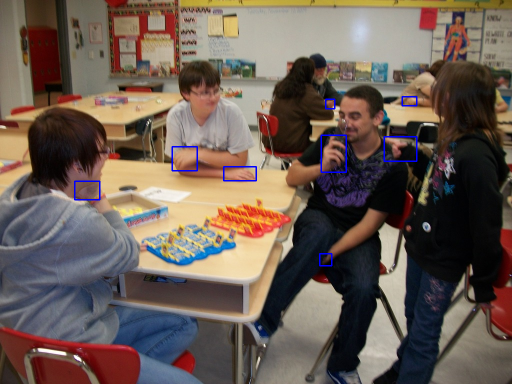

In [22]:
dir_path = '/mydrive/YOLO_toolkit/Dataset' 
show_data_sample(dir_path)        